In [25]:
import hisepy
import os
import pandas as pd
import scanpy as sc

In [26]:
def read_adata_uuid(h5ad_uuid):
    h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)
    if not os.path.isdir(h5ad_path):
        hise_res = hisepy.reader.cache_files([h5ad_uuid])
    h5ad_filename = os.listdir(h5ad_path)[0]
    h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)
    adata = sc.read_h5ad(h5ad_file)
    return adata

In [27]:
def read_parquet_uuid(pq_uuid):
    pq_path = '/home/jupyter/cache/{u}'.format(u = pq_uuid)
    if not os.path.isdir(pq_path):
        hise_res = hisepy.reader.cache_files([pq_uuid])
    pq_filename = os.listdir(pq_path)[0]
    pq_file = '{p}/{f}'.format(p = pq_path, f = pq_filename)
    df = pd.read_parquet(pq_file)
    return df

## Read subclustering and barcode annotations from HISE

In [28]:
cell_class = 'other'

In [29]:
h5ad_uuid = '1eb6ca8c-b8ed-4968-b515-c954497441dc'

In [30]:
adata = read_adata_uuid(h5ad_uuid)

In [31]:
anno_uuid = '09f10d41-3170-4317-ba84-650268fcfcd2'

In [32]:
anno = read_parquet_uuid(anno_uuid)

In [33]:
anno.head()

,barcodes,AIFI_L1,AIFI_L2,AIFI_L3
0,cf7341b848b611ea8957bafe6d70929e,T+Erythocytes doublet,T+Erythocytes doublet,T+Erythocytes doublet
1,cf7400bc48b611ea8957bafe6d70929e,Monocytes+Erythocytes doublet,Monocytes+Erythocytes doublet,Monocytes+Erythocytes doublet
2,cf763b8448b611ea8957bafe6d70929e,T+Erythocytes doublet,T+Erythocytes doublet,T+Erythocytes doublet
3,cf76501a48b611ea8957bafe6d70929e,Progenitor cell,Progenitor cell,CMP cell
4,cf83c0ba48b611ea8957bafe6d70929e,T+Erythocytes doublet,T+Erythocytes doublet,T+Erythocytes doublet


## Add annotations to barcodes

In [34]:
obs = adata.obs
obs = obs.reset_index(drop = True)
obs = obs.merge(anno, on = 'barcodes', how = 'left')
obs = obs.set_index('barcodes', drop = False)

In [35]:
adata.obs = obs

## Drop doublet/contamination labels

In [36]:
exclude_terms = [
    'Contamination', 'contamination',
    'Doublet', 'doublet',
    'Mito', 'mito'
]

In [37]:
all_types = adata.obs['AIFI_L3'].unique().tolist()

In [38]:
exclude_types = []
for cell_type in all_types:
    for term in exclude_terms:
        if term in cell_type:
            exclude_types.append(cell_type)

In [39]:
exclude_types

['T+Erythocytes doublet',
 'Monocytes+Erythocytes doublet',
 'B+Erythocytes doublet',
 'NK+Erythocytes doublet']

In [40]:
keep_types = []
for cell_type in all_types:
    if not cell_type in exclude_types:
        keep_types.append(cell_type)

In [41]:
adata = adata[adata.obs['AIFI_L3'].isin(keep_types)]
adata.shape

(10937, 4305)

## Plot L2 marker expression

In [42]:
l2_markers = [
    'PF4', 'PPBP', 'CD34', 'KIT', 'HBB'
]

Set L2 category order

In [43]:
category_order = [
    'Progenitor cell',
    'Erythrocyte',
    'Platelet'
]

adata.obs['AIFI_L2'] = (
    adata.obs['AIFI_L2']
    .cat
    .set_categories(category_order, ordered=True)
)

/tmp/ipykernel_13685/3378491394.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['AIFI_L2'] = (


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


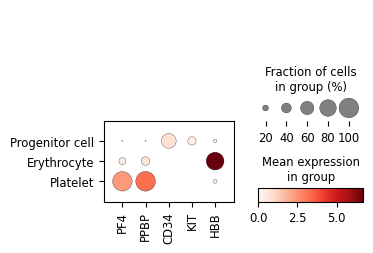

In [44]:
sc.pl.dotplot(
    adata,
    groupby = 'AIFI_L2',
    var_names = l2_markers,
    log = True
)

## Plot L3 marker expression

In [45]:
l3_markers = [
    'PF4', 'PPBP', 'CD34', 'KIT', 'HBB',
    'HDC', 'IL1B', 'JCHAIN'
]

Set L3 category order

In [46]:
category_order = [
    'CLP cell',
    'BaEoMaP cell',
    'CMP cell',
    'Erythrocyte',
    'Platelet'
]

adata.obs['AIFI_L3'] = (
    adata.obs['AIFI_L3']
    .cat
    .set_categories(category_order, ordered=True)
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


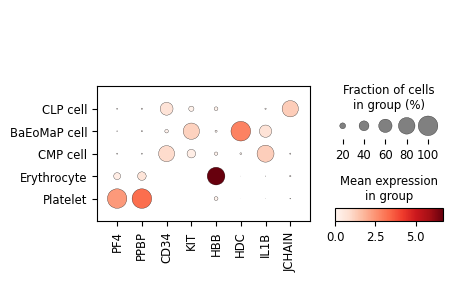

In [47]:
sc.pl.dotplot(
    adata,
    groupby = 'AIFI_L3',
    var_names = l3_markers,
    log = True
)

In [48]:
import session_info
session_info.show()